In [1]:
from rolling.embedding import get_embedding

In [2]:
# embedding test
from scipy.spatial.distance import cosine
def get_similarity(embedding1, embedding2):
    return 1 - cosine(embedding1, embedding2)

results = [
    get_embedding("machine learning"),
    get_embedding("deep learning")
]

similarity = get_similarity(results[0], results[1])
print(similarity)

results = [
    get_embedding("machine learning"),
    get_embedding("cow")
]

similarity = get_similarity(results[0], results[1])
print(similarity)

0.6985033872705319
0.44313470322301296


In [3]:
# load text
# files = ["text1_atari200.txt", "text2_shakespear", "text3_wikipedia.txt"]
files = ["text1_atari200.txt"]
text = ""
for file in files:
    with open(f'texts/{file}', "r", encoding='UTF-8') as f:
        text += f.read()
text = text.replace("\n", " ")
len(text), text[:100]

(28052,
 'Human-level Atari 200x faster Steven Kapturowski1 , Víctor Campos*1, Ray Jiang*1, Nemanja Rakićević1')

In [4]:
def split_text(text, n=512):
    return [text[i:i+n] for i in range(0, len(text), n)]

In [5]:
# generate embedding for all sentences
import numpy as np
from tqdm import tqdm
from dataclasses import dataclass

@dataclass
class Sentence:
    text: str
    embedding: np.ndarray

results = []
parts = split_text(text, 512)
for sentence in tqdm(parts):
    embedding = get_embedding(sentence)
    results.append(Sentence(sentence, embedding))

results[0].text, results[0].embedding.shape, results[0].embedding

100%|██████████| 55/55 [00:00<00:00, 74.80it/s]


('Human-level Atari 200x faster Steven Kapturowski1 , Víctor Campos*1, Ray Jiang*1, Nemanja Rakićević1 , Hado van Hasselt1 , Charles Blundell1 and Adrià Puigdomènech Badia1 1DeepMind, *Equal contribution The task of building general agents that perform well over a wide range of tasks has been an impor\x02tant goal in reinforcement learning since its inception. The problem has been subject of research of a large body of work, with performance frequently measured by observing scores over the wide range of environm',
 (768,),
 array([ 1.98868051e-01,  1.05415082e+00, -3.55517745e+00,  1.83754802e-01,
         8.20932627e-01, -7.63532892e-02,  1.52788270e+00, -4.03974324e-01,
        -3.33955258e-01,  5.77719450e-01,  8.22067261e-02,  4.97762978e-01,
         1.25620306e+00,  3.80036235e-01, -4.23142880e-01, -4.81210947e-01,
        -3.65734659e-02, -1.14032161e+00, -9.09155667e-01, -9.40786302e-03,
         2.69297332e-01, -1.43962431e+00,  8.39840174e-01, -1.33535415e-01,
         1.0317

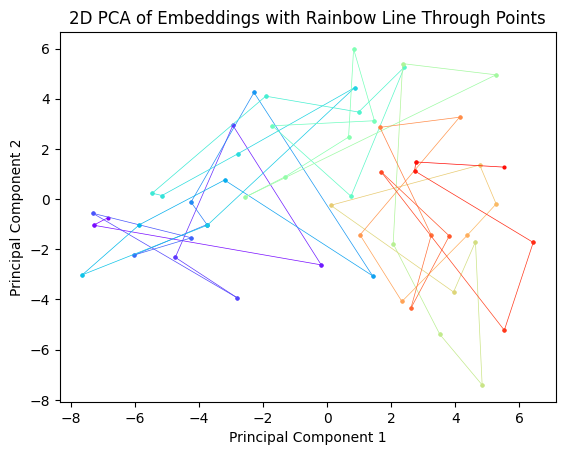

In [6]:
# Visualize
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# Assuming embeddings are extracted as shown
embeddings = np.array([sentence.embedding for sentence in results])

# Apply PCA to reduce to 2D
pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(embeddings)

# Generate colors
num_points = reduced_embeddings.shape[0]
colors = cm.rainbow(np.linspace(0, 1, num_points))

fig = plt.figure()
ax = fig.add_subplot(111)

# Plot the points and the line through them in rainbow colors
for i in range(num_points - 1):
    ax.plot(reduced_embeddings[i:i+2, 0], reduced_embeddings[i:i+2, 1], color=colors[i], marker='o', markersize=2,linewidth=0.5)

plt.title('2D PCA of Embeddings with Rainbow Line Through Points')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()


---

In [7]:
import nltk
from nltk.tokenize import sent_tokenize

# Download required resources
nltk.download('punkt')
nltk.download('punkt_tab')

# Split the text into sentences
sentences = sent_tokenize(text)

# Print the split sentences
for sentence in sentences[:3]:
    print(sentence)


Human-level Atari 200x faster Steven Kapturowski1 , Víctor Campos*1, Ray Jiang*1, Nemanja Rakićević1 , Hado van Hasselt1 , Charles Blundell1 and Adrià Puigdomènech Badia1 1DeepMind, *Equal contribution The task of building general agents that perform well over a wide range of tasks has been an important goal in reinforcement learning since its inception.
The problem has been subject of research of a large body of work, with performance frequently measured by observing scores over the wide range of environments contained in the Atari 57 benchmark.
Agent57 was the first agent to surpass the human benchmark on all 57 games, but this came at the cost of poor data-efficiency, requiring nearly 80 billion frames of experience to achieve.


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Tobias\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\Tobias\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [8]:
from rolling.paper import create_paper, print_paper, save_paper, load_paper

In [9]:
paper = create_paper('test', text)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Tobias\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\Tobias\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [10]:
print_paper(paper)

Paper: test
> [ 0.71496713  1.38890755 -2.87749505] Human-level Atari 200x faster Steven Kapturowski1 , Víctor Campos*1, Ray Jiang*1, Nemanja Rakićević1 , Hado van Hasselt1 , Charles Blundell1 and Adrià Puigdomènech Badia1 1DeepMind, *Equal contribution The task of building general agents that perform well over a wide range of tasks has been an important goal in reinforcement learning since its inception. The problem has been subject of research of a large body of work, with performance frequently measured by observing scores over the wide range of environments contained in the Atari 57 benchmark. Agent57 was the first agent to surpass the human benchmark on all 57 games, but this came at the cost of poor data-efficiency, requiring nearly 80 billion frames of experience to achieve. Taking Agent57 as a starting point, we employ a diverse set of strategies to achieve a 200-fold reduction of experience needed to outperform the human baseline. We investigate a range of instabilities and 

In [11]:
save_paper(paper, 'test_paper.pkl')

In [12]:
paper = load_paper('test_paper.pkl')

In [13]:
print_paper(paper)

Paper: test
> [ 0.71496713  1.38890755 -2.87749505] Human-level Atari 200x faster Steven Kapturowski1 , Víctor Campos*1, Ray Jiang*1, Nemanja Rakićević1 , Hado van Hasselt1 , Charles Blundell1 and Adrià Puigdomènech Badia1 1DeepMind, *Equal contribution The task of building general agents that perform well over a wide range of tasks has been an important goal in reinforcement learning since its inception. The problem has been subject of research of a large body of work, with performance frequently measured by observing scores over the wide range of environments contained in the Atari 57 benchmark. Agent57 was the first agent to surpass the human benchmark on all 57 games, but this came at the cost of poor data-efficiency, requiring nearly 80 billion frames of experience to achieve. Taking Agent57 as a starting point, we employ a diverse set of strategies to achieve a 200-fold reduction of experience needed to outperform the human baseline. We investigate a range of instabilities and 